# Importing Libraries and Installing Packages

In [ ]:
!pip install sightengine
!pip install image-quality

     |████████████████████████████████| 153kB 9.6MB/s 
     |████████████████████████████████| 174kB 43.4MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp36-cp36m-linux_x86_64.whl size=233323 sha256=3a9f08c3edd94ec898abf36a472a51d41ad08c6bd1b30cc43272a09b67b2d523
  Stored in directory: /root/.cache/pip/wheels/5e/9e/b5/dbb033107407eec2f52b8cd24cf024a4b9ec8b62ea5aee995a
Successfully built libsvm


In [ ]:
from google.colab import drive
from sightengine.client import SightengineClient
import imquality.brisque as brisque
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from time import time
import matplotlib.patheffects as path_effects
import pickle

# Nothing important, just to make colors white
# to see them better, since the background is gray
params = {"ytick.color" : "c",
          "xtick.color" : "c",
          "axes.labelcolor" : "c",
          "axes.edgecolor" : "c",
          "text.color" : "c"}
plt.rcParams.update(params)
%matplotlib inline

from skimage.feature import canny
from math import atan2, pi

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/data_')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Counting how many files inside a folder recursively

In [ ]:
def num_files(folder, valid_ext=None):
    if isinstance(valid_ext, str):
        return num_files(folder, [valid_ext])
    elif (isinstance(valid_ext, list) and all([isinstance(i, str) for i in valid_ext])) or valid_ext is None:
        if os.path.isfile(folder):
            if valid_ext is None or folder.split('.')[-1] in valid_ext:
                return 1
            return 0
        return sum(num_files(os.path.join(folder, f), valid_ext) for f in os.listdir(folder))
    raise ValueError(f'valid_ext can be string or list of strings.')

In [ ]:
num_files('train')

1983

# Loading random images and caching their `sightengine` values

In [ ]:
client = SightengineClient('54728470', 'HWFs4bVA7cvcdqL9sW7x')

total_num_images = num_files('train')
indices = np.random.choice(total_num_images, size=100)
i = 0
X = []
google_values = []
for room in os.listdir('train'):
    room_path = os.path.join('train', room)
    for filename in os.listdir(room_path):
        if i in indices:
            path = os.path.join(room_path, filename)
            image = cv2.imread(path)
            
            google_values_filename = '.'.join(filename.split('.')[:-1]) + '.pkl'
            google_values_path = f'../train_google_values/{room}/{google_values_filename}'
            if os.path.exists(google_values_path):
                print(f'Reading from the cache {google_values_path} at image {len(X)}')
                with open(google_values_path, 'rb') as file:
                    output = pickle.load(file)
            else:
                # TODO: safety check if sightengine api limit exceeded
                output = client.check('properties').set_file(path)
                with open(google_values_path, 'wb') as file:
                    pickle.dump(output, file)
            
            google_values.append(output)
            X.append(image)

        i += 1

Reading from the cache ../train_google_values/Room/room (290).pkl at i: 213
Reading from the cache ../train_google_values/Room/room (323).pkl at i: 247
Reading from the cache ../train_google_values/Kitchen/kitchen (126).pkl at i: 1468
Reading from the cache ../train_google_values/Kitchen/kitchen (28).pkl at i: 1623


# Pycontrast Function

In [ ]:
from skimage import io
from skimage import exposure
from skimage import color
from skimage import img_as_float
from sklearn.metrics import mutual_info_score as mis
def pycontrast(input_image, num_bins=128):
    """
    Computes a score of the quality of contrast in input image based on divergence
    from an intensity equalized histogram.
    We compute the mutual information (MI) (a measure of entropy) between histogram of intensity
    of image and its contrast equalized histogram.
    MI is not real metric, but a symmetric and non-negative similarity measures that
    takes high values for similar images. Negative values are also possible.
    Intuitively, mutual information measures the information that histogram_image and histogram_equlized
    share: it measures how much knowing one of these variables reduces uncertainty about the other.
    The Entropy is defined as:
    .. math::
        H(X) = - \sum_i p(g_i) * ln(p(g_i)
    with :math:`p(g_i)` being the probability of the images intensity value :math:`g_i`.
    Assuming two histograms :math:`R` and :math:`T`, the mutual information is then computed by comparing the
    histogram entropy values (i.e. a measure how well-structured the common histogram is).
    The distance metric is then calculated as follows:
    .. math::
        MI(R,T) = H(R) + H(T) - H(R,T) = H(R) - H(R|T) = H(T) - H(T|R)
    A maximization of the mutual information is equal to a minimization of the joint
    entropy.
    :param input_image : 2-D array
    :param num_bins :  integer : the number of bins in histogram, it has a small scaling effect on
    the mutual information score since it slightly modifies the shape of the histogram
    :return: quality of contrast : float
    :raises: argument error if input image data is corrupted
    """

    # Check dimensions of input image
    # If image dimensions is 2, then it is a gray-scale image
    # First convert input to RGB image
    if input_image.shape == 2:
        input_image = color.gray2rgb(input_image)

    # Convert the RGB image to HSV. Exposure is primarily correlated with Value rather
    # than Hue and Saturation
    image_hsv = color.rgb2hsv(input_image)

    # The intensity channel is third in HSV format image
    v_channel = image_hsv[:, :, 2]

    # compute the contrast equalized array of intensity channel of image
    v_channel_equalized = exposure.equalize_hist(v_channel, nbins=num_bins)

    # compute the histogram of intensity channel
    v_channel_histogram, histogram_bin_edges = np.histogram(img_as_float(v_channel), bins=num_bins, density=True)

    # compute the histogram of contrast equalized intensity channel
    v_channel_equalized_histogram, _ = np.histogram(img_as_float(v_channel_equalized), bins=num_bins, density=True, range=(histogram_bin_edges[0], histogram_bin_edges[-1]))

    # compute the mutual information based contrast quality measure
    return mis(v_channel_histogram, v_channel_equalized_histogram)

# Code converted from MATLAB

In [ ]:
def matlab_contrast(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    assert len(image.shape) == 2, "'image' needs to be a grayscale image"
    # 9 different resolution levels
    GCF = 0
    resolutions = [1, 2, 4, 8, 16, 25, 50, 100, 200]    
    LC = np.zeros(len(resolutions))
    for i, res in enumerate(resolutions):
        
        W = image.shape[1] // res
        H = image.shape[0] // res
        
        # attempt at resizing as in the paper
        rImage = cv2.resize(image, (W, H))
        # compute linear luminance l
        l = (rImage.astype(np.float) / 255) * 2.2
        # compute perceptual luminance L
        rL = 100 * np.sqrt(l)
        
        # compute local contrast for each pixel
        lc = 0
        for x in range(H):
            for y in range(W):
                if x == 0:
                    if y == 0: 
                        lc += (np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x+1, y])) / 2
                    elif y == W - 1:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x+1, y])) / 2
                    else:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x+1, y])) / 3
                    
                elif x == H - 1:
                    if y == 0:
                        lc += (np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x-1, y])) / 2
                    elif y == W - 1:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x-1, y])) / 2
                    else: 
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x-1, y])) / 3
                    
                else:
                    if y == 0:
                        lc += (np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x+1, y]) + np.abs(rL[x, y] - rL[x-1, y])) / 3
                    elif y == W - 1:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x+1, y]) + np.abs(rL[x, y] - rL[x-1, y])) / 3
                    else:
                        lc += (np.abs(rL[x, y] - rL[x, y-1]) + np.abs(rL[x, y] - rL[x, y+1]) + np.abs(rL[x, y] - rL[x-1, y]) + np.abs(rL[x, y] - rL[x+1, y])) / 4
        
        # compute average local contrast c
        ci = lc / (W * H)
        wi = (-0.406385 * (i / 9) + 0.334573) * (i / 9) + 0.0877526
        
        # compute global contrast factor
        LC[i] = ci * wi
        GCF = GCF + LC[i]
        
    return GCF #, LC

# `Brisque`, `Pycontrast`, `MATLAB` vs `Sightengine`

In [ ]:
google_contrast = [g['contrast'] for g in google_values]
brisque_values = [brisque.score(image) for image in X]
pycontrast_values = [pycontrast(image) for image in X]
matlab_values = [matlab_contrast(image) for image in X]

### Sorting both measures by `Sightengine` values


In [ ]:
brisque_values = [x for _, x in sorted(zip(google_contrast, brisque_values))]
pycontrast_values = [x for _, x in sorted(zip(google_contrast, pycontrast_values))]
matlab_values = [x for _, x in sorted(zip(google_contrast, matlab_values))]
google_contrast = sorted(google_contrast)

### Plotting the result

`methods` to be plotted

In [ ]:
methods = [('Brisque', brisque_values),
           ('Pycontrast', pycontrast_values),
           ('MATLAB', matlab_values)]

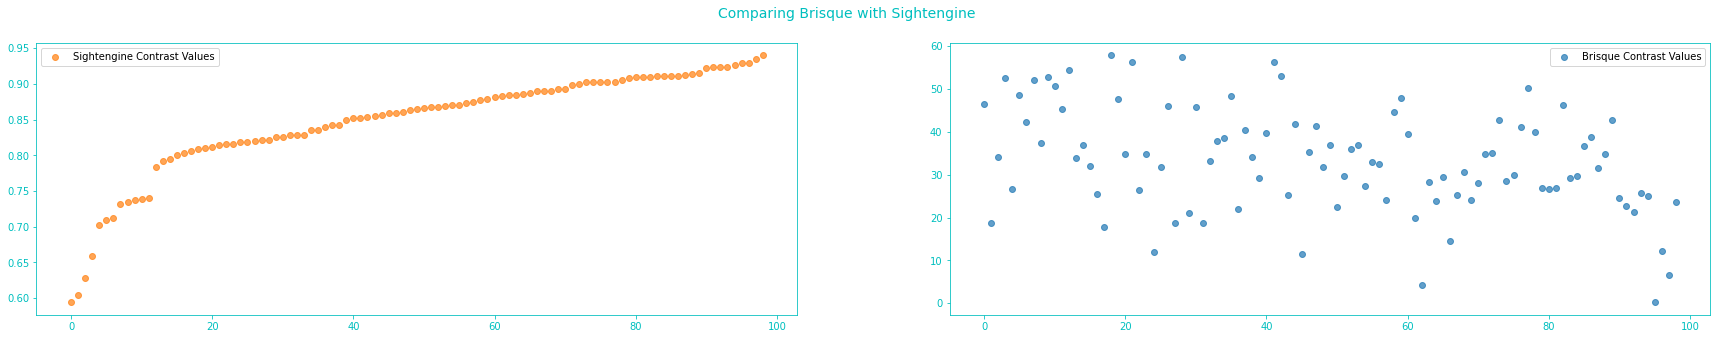

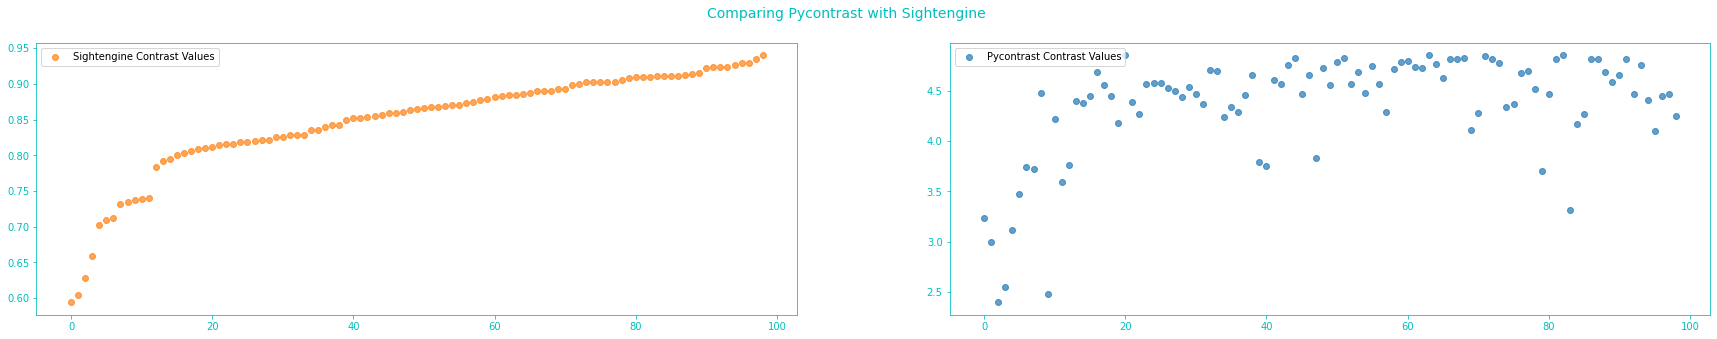

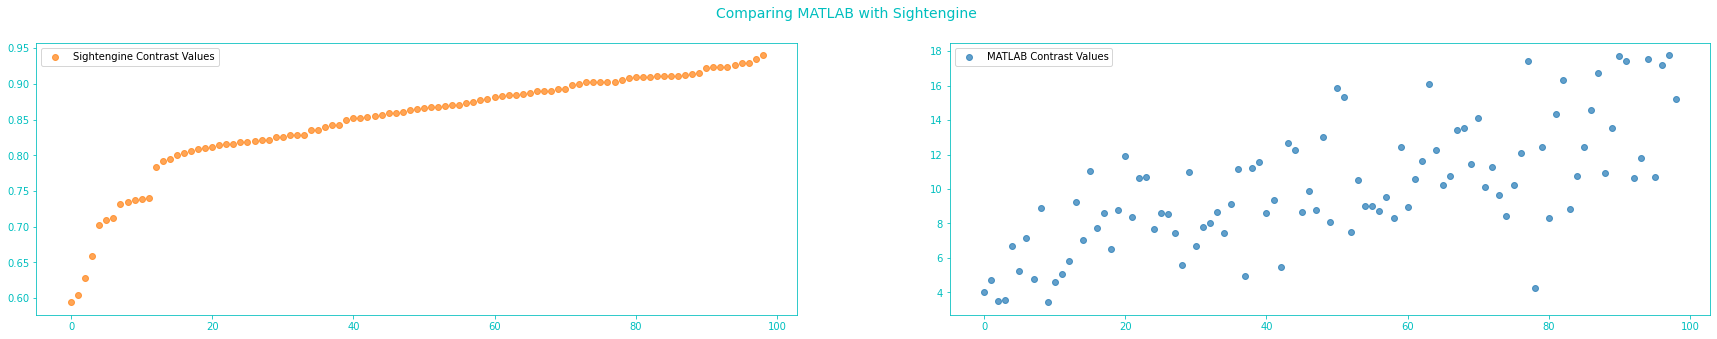

In [ ]:
x = np.arange(len(X))
for name, values in methods:
    fig, [left, right] = plt.subplots(1, 2, figsize=(30, 5))
    plt.suptitle(f'Comparing {name} with Sightengine', color='c', fontsize=14)
    left.scatter(x, google_contrast, label=f'Sightengine Contrast Values', alpha=0.7, color='C1')
    right.scatter(x, values, label=f'{name} Contrast Values', alpha=0.7, color='C0')
    l = left.legend()
    for text in l.get_texts():
        text.set_color('black')
    l = right.legend()
    for text in l.get_texts():
        text.set_color('black')
    plt.show()